In [10]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [28]:
DATASET_PATH = "/content/extracted_data"
SAMPLE_RATE = 22050
DURATION = 3.0
N_MELS = 128
TARGET_LENGTH = int(SAMPLE_RATE * DURATION)

In [29]:
def clean_audio(y):
    y_trimmed, _ = librosa.effects.trim(y, top_db=30)
    if len(y_trimmed) > TARGET_LENGTH:
        start = (len(y_trimmed) - TARGET_LENGTH) // 2
        return y_trimmed[start : start + TARGET_LENGTH]
    else:
        padding = TARGET_LENGTH - len(y_trimmed)
        return np.pad(y_trimmed, (0, padding), 'constant')

def get_spectrogram(y, sr):
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    return librosa.power_to_db(mels, ref=np.max)

def add_noise(y):
    noise_amp = 0.005 * np.random.uniform() * np.amax(y)
    return y + noise_amp * np.random.normal(size=y.shape[0])

def pitch_shift(y, sr):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

In [33]:
emotion_map = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }

data = []
for root, dirs, files in os.walk(DATASET_PATH):
        for file in files:
            if file.endswith(".wav"):
                parts = file.split("-")
                if len(parts) < 7:
                    continue

                emotion = emotion_map.get(parts[2])
                actor_id = int(parts[6].split('.')[0])
                gender = 'male' if actor_id % 2 == 1 else 'female'

                if emotion:
                    data.append({
                        'path': os.path.join(root, file),
                        'emotion': emotion,
                        'gender': gender
                    })

df = pd.DataFrame(data)
print(f"Loaded {len(df)} files.")

Loaded 2880 files.


In [34]:
X, y, genders = [], [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
            sig, _ = librosa.load(row['path'], sr=SAMPLE_RATE)
            cleaned = clean_audio(sig)

            spec = get_spectrogram(cleaned, SAMPLE_RATE)
            X.append(spec)
            y.append(row['emotion'])
            genders.append(row['gender'])

            noisy = add_noise(cleaned)
            spec_noisy = get_spectrogram(noisy, SAMPLE_RATE)
            X.append(spec_noisy)
            y.append(row['emotion'])
            genders.append(row['gender'])

            pitched = pitch_shift(cleaned, SAMPLE_RATE)
            spec_pitch = get_spectrogram(pitched, SAMPLE_RATE)
            X.append(spec_pitch)
            y.append(row['emotion'])
            genders.append(row['gender'])

X = np.array(X)[..., np.newaxis]
y = np.array(y)
genders = np.array(genders)

100%|██████████| 2880/2880 [03:46<00:00, 12.73it/s]


In [35]:
encoder = LabelEncoder()
y_enc = to_categorical(encoder.fit_transform(y))
np.save('classes.npy', encoder.classes_)
X_temp, X_test, y_temp, y_test, g_temp, g_test = train_test_split(
        X, y_enc, genders, test_size=0.1, stratify=y_enc, random_state=42
    )
X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42
    )

print(f"Train set: {X_train.shape}")
print(f"Val set:   {X_val.shape}")
print(f"Test set:  {X_test.shape}")

Train set: (6912, 128, 130, 1)
Val set:   (864, 128, 130, 1)
Test set:  (864, 128, 130, 1)


In [36]:
model = Sequential([
        Input(shape=X.shape[1:]),

        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.1),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.1),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.1),

        GlobalAveragePooling2D(),

        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(len(encoder.classes_), activation='softmax')
    ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4),
        ModelCheckpoint('emotion_model.keras', save_best_only=True)
    ]
history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=callbacks
    )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,648 (502.53 KB)

 Trainable params: 128,200 (500.78 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.3035 - loss: 1.7955 - val_accuracy: 0.1574 - val_loss: 2.0854 - learning_rate: 0.0010
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5049 - loss: 1.2933 - val_accuracy: 0.4769 - val_loss: 1.4268 - learning_rate: 0.0010
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6226 - loss: 1.0177 - val_accuracy: 0.1366 - val_loss: 6.5946 - learning_rate: 0.0010
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7098 - loss: 0.8013 - val_accuracy: 0.5324 - val_loss: 1.3220 - learning_rate: 0.0010
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7741 - loss: 0.6296 - val_accuracy: 0.4780 - val_loss: 1.8528 - learning_rate: 0.0010
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8168 - loss: 0.5123 - val_accuracy: 0.6516 - val_loss: 1.0678 - learning_rate: 0.0010
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8797 - loss: 0


Evaluating Model on Test Set...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

--- Overall Classification Report ---
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       116
        calm       0.96      1.00      0.98       115
     disgust       1.00      1.00      1.00       115
     fearful       1.00      0.97      0.98       115
       happy       0.97      0.98      0.98       115
     neutral       0.92      1.00      0.96        58
         sad       0.99      0.94      0.96       115
   surprised       0.98      0.97      0.98       115

    accuracy                           0.98       864
   macro avg       0.98      0.98      0.98       864
weighted avg       0.98      0.98      0.98       864

Macro F1-Score: 0.9801

--- Gender Bias Analysis (Pitch Bias Check) ---
Total Test Samples: 864
Male Samples: 458
Female Samples: 406

[Male Speakers Performance]
              precision    recall  f1-score   support

       angry       1

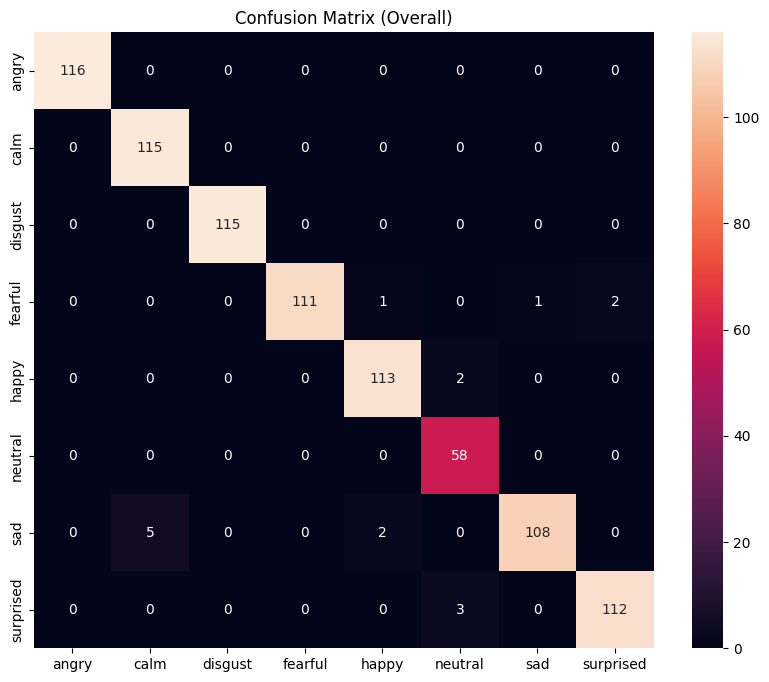

In [37]:
print("\nEvaluating Model on Test Set...")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n--- Overall Classification Report ---")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))
print(f"Macro F1-Score: {f1_score(y_true, y_pred, average='macro'):.4f}")

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix (Overall)")

print("\n--- Gender Bias Analysis (Pitch Bias Check) ---")

male_indices = np.where(g_test == 'male')[0]
female_indices = np.where(g_test == 'female')[0]

print(f"Total Test Samples: {len(y_test)}")
print(f"Male Samples: {len(male_indices)}")
print(f"Female Samples: {len(female_indices)}")

if len(male_indices) > 0:
        print("\n[Male Speakers Performance]")
        print(classification_report(y_true[male_indices], y_pred[male_indices],
                                    target_names=encoder.classes_))

if len(female_indices) > 0:
        print("\n[Female Speakers Performance]")
        print(classification_report(y_true[female_indices], y_pred[female_indices],
                                    target_names=encoder.classes_))

print("\nTraining script completed successfully.")